In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

In [11]:
basket = pd.read_csv("./Data/Groceries_dataset.csv")
basket.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


_These individual transactions need to be grouped into basket of items_

In [12]:
basket = basket.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index()
basket.head()

,Member_number,Date,itemDescription
0,1000,15-03-2015,"[sausage, whole milk, semi-finished bread, yog..."
1,1000,24-06-2014,"[whole milk, pastry, salty snack]"
2,1000,24-07-2015,"[canned beer, misc. beverages]"
3,1000,25-11-2015,"[sausage, hygiene articles]"
4,1000,27-05-2015,"[soda, pickled vegetables]"


In [15]:
basket.shape

(14963, 3)

In [14]:
# Encode the Transaction Data
te = TransactionEncoder()
te_ary = te.fit(basket['itemDescription']).transform(basket['itemDescription'])
df = pd.DataFrame(te_ary, columns=te.columns_)
df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
df.shape

(14963, 167)

### Aprori Algorithm

In [17]:
frequent_itemsets = apriori(df, min_support=6/basket.shape[0], use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.004010,(Instant food products)
1,0.021386,(UHT-milk)
2,0.001470,(abrasive cleaner)
3,0.001938,(artif. sweetener)
4,0.008087,(baking powder)


In [18]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(butter milk),(UHT-milk),0.017577,0.021386,0.000601,0.034221,1.600131,0.000226,1.013289
1,(UHT-milk),(butter milk),0.021386,0.017577,0.000601,0.028125,1.600131,0.000226,1.010854
2,(cream cheese ),(UHT-milk),0.023658,0.021386,0.000869,0.036723,1.717152,0.000363,1.015922
3,(UHT-milk),(cream cheese ),0.021386,0.023658,0.000869,0.040625,1.717152,0.000363,1.017685
4,(soda),(artif. sweetener),0.097106,0.001938,0.000468,0.004818,2.485725,0.000280,1.002893


In [19]:
print(f"No. of Rules: {rules.shape[0]}")

No. of Rules: 522


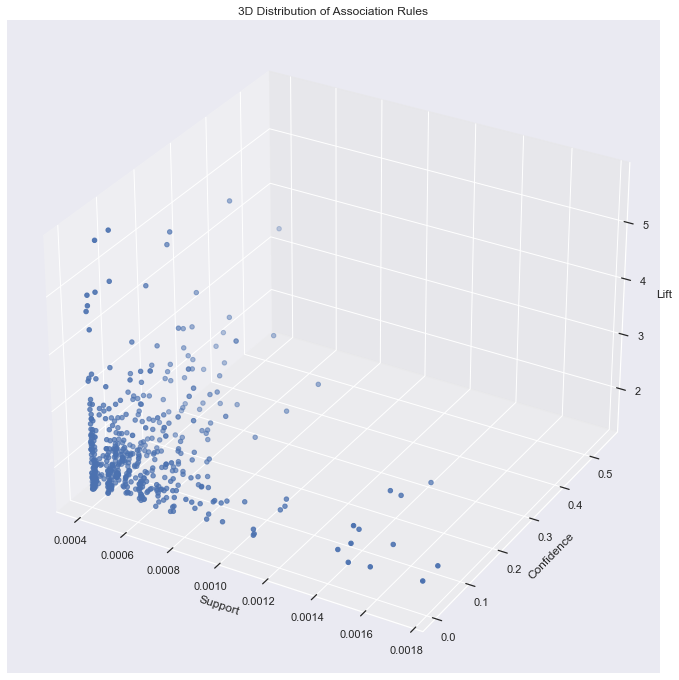

In [22]:
sns.set(style = "darkgrid")
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection = '3d')


x = rules['support']
y = rules['confidence']
z = rules['lift']

ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
ax.set_zlabel("Lift")

ax.scatter(x, y, z)
ax.set_title("3D Distribution of Association Rules")

plt.show()

### Rules Graph

<>:24: DeprecationWarning: invalid escape sequence \d
<>:24: DeprecationWarning: invalid escape sequence \d
C:\Users\Subha\AppData\Local\Temp\ipykernel_26176\3680248427.py:24: DeprecationWarning: invalid escape sequence \d
  if re.compile("^[R]\d+$").fullmatch(node) != None:


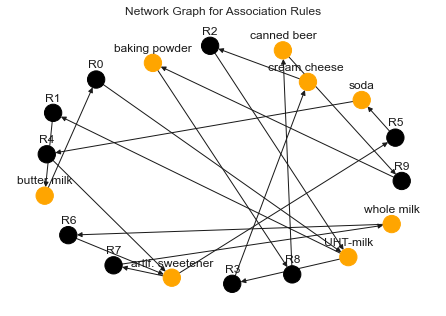

In [25]:
def draw_network(rules, rules_to_show):
  # Directional Graph from NetworkX
  network = nx.DiGraph()
  
  # Loop through number of rules to show
  for i in range(rules_to_show):
    
    # Add a Rule Node
    network.add_nodes_from(["R"+str(i)])
    for antecedents in rules.iloc[i]['antecedents']: 
        # Add antecedent node and link to rule
        network.add_nodes_from([antecedents])
        network.add_edge(antecedents, "R"+str(i),  weight = 2)
      
    for consequents in rules.iloc[i]['consequents']:
        # Add consequent node and link to rule
        network.add_nodes_from([consequents])
        network.add_edge("R"+str(i), consequents,  weight = 2)

  color_map=[]  
  
  # For every node, if it's a rule, colour as Black, otherwise Orange
  for node in network:
       if re.compile("^[R]\d+$").fullmatch(node) != None:
            color_map.append('black')
       else:
            color_map.append('orange')
  
  # Position nodes using spring layout
  pos = nx.spring_layout(network, k=16, scale=1)
  # Draw the network graph
  nx.draw(network, pos, node_color = color_map, font_size=8)            
  
  # Shift the text position upwards
  for p in pos:  
      pos[p][1] += 0.12

  nx.draw_networkx_labels(network, pos)
  plt.title("Network Graph for Association Rules")
  plt.show()

draw_network(rules, 10)

__Business Application__

Let’s say the grocery has bought up too much Whole Milk and is now worrying that the stocks will expire <br>
if they cannot be sold out in time. To make matters worse, the profit margin of Whole Milk is so low that <br>
they cannot afford to have a promotional discount without killing too much of their profits.

`One approach that can be proposed is to find out which products drive the sales of Whole Milk and
offer discounts on those products instead.`

In [32]:
milk_rules = rules[rules['consequents'].astype(str).str.contains('whole milk')]

In [33]:
# Sort the milk rules by lift and confidence
milk_rules = milk_rules.sort_values(['confidence', 'lift'], ascending = [False, False])
milk_rules = milk_rules.reset_index(drop=True)
milk_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(hygiene articles, canned beer)",(whole milk),0.000735,0.157923,0.000401,0.545455,3.453930,0.000285,1.852570
1,"(pork, sausage)",(whole milk),0.001537,0.157923,0.000601,0.391304,2.477819,0.000359,1.383412
2,"(beef, bottled beer)",(whole milk),0.001069,0.157923,0.000401,0.375000,2.374577,0.000232,1.347323
3,"(yogurt, onions)",(whole milk),0.001270,0.157923,0.000468,0.368421,2.332918,0.000267,1.333289
4,"(sugar, other vegetables)",(whole milk),0.001270,0.157923,0.000468,0.368421,2.332918,0.000267,1.333289


For instance, we can apply a promotional discount on hygiene articles, canned beer, pork and sausage. Some of the associations may seem counter-intuitive, but the rules state that these products do drive the sales of Whole Milk.